In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as CM 
from sklearn import model_selection 
from sklearn.model_selection import learning_curve 
from sklearn.metrics import precision_recall_curve 

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
%matplotlib inline

In [7]:
# data generation
data = pd.read_csv("C:/Users/jstep/Downloads/german_credit_data/german.data", sep=" ",header=None)
col_mapping = {0:"checking_account", 
               1:"duration",
               2:"credit_history",
               3:"purpose",
               4:"credit_amt",
               5:"savings_acct",
               6:"employment",
               7:"installment_rate_percent",
               8:"gender_status",
               9:"other_debtors",
              10:"residence_since",
              11:"property",
              12:"age",
              13:"other_installment_plans",
              14:"housing",
              15:"no_existing_credits",
              16:"job",
              17:"no_people_liable",
              18:"has_telephone",
              19:"is_foreign_worker",
              20:"good_bad"}
data.columns = [col_mapping[col] for col in data.columns]
data["good_bad"] = np.where(data["good_bad"] == 2, 1, 0)
data = pd.get_dummies(data, drop_first=True)

# 
bad_data = data[data["good_bad"] == 1]
good_data = data[data["good_bad"] == 0]
small_sample_bad_data = bad_data.sample(50)
final_data = pd.concat([good_data,small_sample_bad_data], axis=0)


In [10]:
predictors = [c for c in final_data.columns if c != 'good_bad']
target = 'good_bad'

In [12]:
X = final_data[predictors].values
y = final_data["good_bad"].values

In [32]:
from tqdm import tqdm
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in tqdm(k_values):
    model = XGBClassifier(learning_rate = 0.01, n_estimators=2000, 
                            max_depth=20, objective = "binary:logistic")
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]

    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores_over = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
    print(f"k={k}\n")
    print(f"mean recall: {np.mean(scores_over)}\n")
    print(scores_over)


  0%|          | 0/7 [00:00<?, ?it/s]

k=1

mean recall: 0.44000000000000006

[0.2 0.6 0.4 0.4 0.6 0.  0.2 0.8 0.4 0.8]



 14%|█▍        | 1/7 [00:07<00:47,  7.94s/it]

k=2

mean recall: 0.4

[0.2 0.6 0.4 0.8 0.2 0.4 0.2 0.4 0.6 0.2]



 29%|██▊       | 2/7 [00:15<00:39,  7.83s/it]

k=3

mean recall: 0.48

[0.6 0.6 0.6 0.2 0.6 0.4 0.2 0.4 0.4 0.8]



 43%|████▎     | 3/7 [00:23<00:31,  7.98s/it]

k=4

mean recall: 0.4999999999999999

[0.4 0.6 0.6 0.4 0.4 0.4 0.4 0.6 0.6 0.6]



 57%|█████▋    | 4/7 [00:32<00:24,  8.24s/it]

k=5

mean recall: 0.5399999999999999

[0.6 0.6 0.6 0.6 0.6 0.2 0.4 0.6 0.6 0.6]



 71%|███████▏  | 5/7 [00:41<00:16,  8.45s/it]

k=6

mean recall: 0.52

[0.6 0.8 0.4 0.6 0.6 0.2 0.2 0.8 0.6 0.4]



 86%|████████▌ | 6/7 [00:49<00:08,  8.40s/it]

k=7

mean recall: 0.48

[0.4 0.8 0.8 0.4 0.2 0.2 0.4 0.6 0.4 0.6]



100%|██████████| 7/7 [00:57<00:00,  8.22s/it]

In [ ]:
# k=5 is best
# now build a model and check precision

In [106]:
model = XGBClassifier(learning_rate = 0.01, n_estimators=2000, 
                        max_depth=20, objective = "binary:logistic")
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]

pipeline = Pipeline(steps=steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
pipeline.fit(X_train, y_train)

yhat_test =pipeline.predict(X_test)
yhat_test_prob = pipeline.predict_proba(X_test)[:,1]  

# yhat_test = np.where(yhat_test_prob>0.5,1,0)

confusion_matrix = CM(y_test,  yhat_test, np.unique(y_train))

precision = round(precision_score(y_test, yhat_test, average='binary')*100)
recall = round(recall_score(y_test, yhat_test, average='binary')*100)

print(f"confusion_matrix: \n {confusion_matrix}")
print(f"precision: {precision}%")
print(f"recall: {recall}%")

C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


confusion_matrix: 
 [[187  24]
 [  8   6]]
precision: 20%
recall: 43%


Text(0, 0.5, 'Proportion')

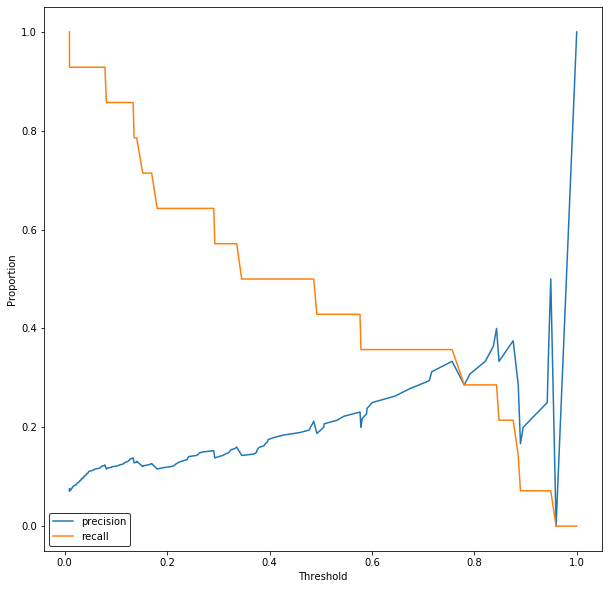

In [108]:
precision_ls, recall_ls, thresholds_ls = precision_recall_curve(y_test, yhat_test_prob)
thresholds_ls = np.append(thresholds_ls, 1)
plt.figure(figsize=(10,10))
plt.plot(thresholds_ls, precision_ls)
plt.plot(thresholds_ls, recall_ls)
Legend = plt.legend(('precision', 'recall'), frameon=True, loc='best') 
Legend.get_frame().set_edgecolor('k')  
plt.xlabel('Threshold')  
plt.ylabel('Proportion') 

Text(0, 0.5, 'precision')

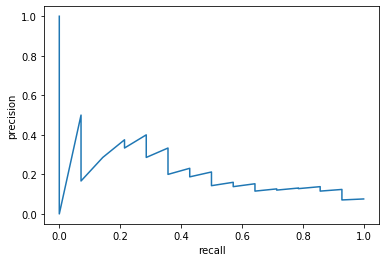

In [109]:
plt.plot(recall_ls, precision_ls)
plt.xlabel('recall')  
plt.ylabel('precision') 

In [110]:
pd.set_option('display.max_rows', 500)
recall_precision_data = pd.DataFrame({"Recall":recall_ls, 
              "Precision":precision_ls,
              "Threshold":thresholds_ls})

In [111]:
# for a given threshold, calculate tp,tn,fp,fn
test_vs_hat = pd.DataFrame({"y_test":y_test, "yhat_test_prob":yhat_test_prob})

In [133]:
threshold_data = pd.DataFrame()
for i, row in recall_precision_data.iterrows():
    test_vs_hat["y_hat"] = np.where(test_vs_hat["yhat_test_prob"] >= row["Threshold"],1,0)
    c_matrix = CM(test_vs_hat["y_test"],test_vs_hat["y_hat"],np.unique(test_vs_hat["y_test"]))
    
    precision = round(precision_score(test_vs_hat["y_test"], test_vs_hat["y_hat"], average='binary')*100)
    recall = round(recall_score(test_vs_hat["y_test"], test_vs_hat["y_hat"], average='binary')*100)

    print(precision)
    print(recall)
    print(row["Threshold"])
    print(c_matrix)
    threshold_data_row = pd.DataFrame({"Threshold":[row["Threshold"]],
                                       "tn":[c_matrix[0][0]],
                                       "tp":[c_matrix[1][1]], 
                                       "fp":[c_matrix[0][1]],
                                       "fn":[c_matrix[1][0]]})
    threshold_data = threshold_data.append(threshold_data_row)

C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
100
0.009160001762211323
[[ 40 171]
 [  0  14]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.009163160808384418
[[ 40 171]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.009293955750763416
[[ 41 170]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.00954799260944128
[[ 42 169]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.009706486947834492
[[ 43 168]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.010020839050412178
[[ 44 167]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.011148017831146717
[[ 45 166]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.012095523998141289
[[ 46 165]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.01211626548320055
[[ 47 164]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.01219319086521864
[[ 48 163]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.0123807517811656
[[ 49 162]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


7
93
0.012512569315731525
[[ 50 161]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.012592179700732231
[[ 51 160]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.012606821022927761
[[ 52 159]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.012782116420567036
[[ 53 158]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.013713777996599674
[[ 54 157]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.014404754154384136
[[ 55 156]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.014590817503631115
[[ 56 155]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.015190488658845425
[[ 57 154]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.015312478877604008
[[ 58 153]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.015385634265840054
[[ 59 152]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.0155413206666708
[[ 60 151]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.01567908748984337
[[ 61 150]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.016123777255415916
[[ 62 149]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.017240352928638458
[[ 63 148]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.017641637474298477
[[ 64 147]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.018536290153861046
[[ 65 146]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.01985863968729973
[[ 66 145]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.02012850157916546
[[ 67 144]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.021861033514142036
[[ 68 143]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.02219686098396778
[[ 69 142]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.022230859845876694
[[ 70 141]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


8
93
0.022711511701345444
[[ 71 140]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.023052219301462173
[[ 72 139]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.023919731378555298
[[ 73 138]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.024400457739830017
[[ 74 137]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.02483995072543621
[[ 75 136]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.02621695026755333
[[ 76 135]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.026869095861911774
[[ 77 134]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.027421152219176292
[[ 78 133]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.028247447684407234
[[ 79 132]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.028930943459272385
[[ 80 131]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.02906954661011696
[[ 81 130]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.029165558516979218
[[ 82 129]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.03066580556333065
[[ 83 128]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.03078310564160347
[[ 84 127]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.03136744722723961
[[ 85 126]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.0327826552093029
[[ 86 125]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


9
93
0.03296806290745735
[[ 87 124]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.03299720585346222
[[ 88 123]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.034032829105854034
[[ 89 122]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.03426055610179901
[[ 90 121]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.03677418828010559
[[ 91 120]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.03681942820549011
[[ 92 119]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.03710425645112991
[[ 93 118]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.037457432597875595
[[ 94 117]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.038365840911865234
[[ 95 116]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.039245594292879105
[[ 96 115]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.039520736783742905
[[ 97 114]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.0414731428027153
[[ 98 113]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.04175170511007309
[[ 99 112]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


10
93
0.04243095591664314
[[100 111]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.0427900031208992
[[101 110]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.04468819499015808
[[102 109]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.04552533105015755
[[103 108]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.04553034529089928
[[104 107]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.046343207359313965
[[105 106]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.046751830726861954
[[106 105]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.04786540940403938
[[107 104]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.052319176495075226
[[108 103]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.05489056929945946
[[109 102]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


11
93
0.05746942013502121
[[110 101]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.058287251740694046
[[111 100]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.06197240948677063
[[112  99]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.0673372745513916
[[113  98]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.06974206864833832
[[114  97]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.0705161914229393
[[115  96]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.07092005014419556
[[116  95]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.07286369055509567
[[117  94]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.078341044485569
[[118  93]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
93
0.07846269756555557
[[119  92]
 [  1  13]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.08131961524486542
[[119  92]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.08242936432361603
[[120  91]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.08433058112859726
[[121  90]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.09084855020046234
[[122  89]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.09173744916915894
[[123  88]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.09979969263076782
[[124  87]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.1044808030128479
[[125  86]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.1073993667960167
[[126  85]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
86
0.1118035539984703
[[127  84]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.11485959589481354
[[128  83]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.11660260707139969
[[129  82]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.11787455528974533
[[130  81]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.12283479422330856
[[131  80]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.12439844012260437
[[132  79]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.12667058408260345
[[133  78]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
86
0.12686757743358612
[[134  77]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
86
0.12953715026378632
[[135  76]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
86
0.1335936039686203
[[136  75]
 [  2  12]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
79
0.13544335961341858
[[136  75]
 [  3  11]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
79
0.1399892419576645
[[137  74]
 [  3  11]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
79
0.14048372209072113
[[138  73]
 [  3  11]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
71
0.1522984504699707
[[138  73]
 [  4  10]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
71
0.15357248485088348
[[139  72]
 [  4  10]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
71
0.1607399582862854
[[140  71]
 [  4  10]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
71
0.1667192429304123
[[141  70]
 [  4  10]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
71
0.16978363692760468
[[142  69]
 [  4  10]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.18051302433013916
[[142  69]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.18666335940361023
[[143  68]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.19401134550571442
[[144  67]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.2053019255399704
[[145  66]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.21219368278980255
[[146  65]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.21496649086475372
[[147  64]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


12
64
0.21600592136383057
[[148  63]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
64
0.21919400990009308
[[149  62]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
64
0.22176404297351837
[[150  61]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
64
0.22592207789421082
[[151  60]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
64
0.2324827015399933
[[152  59]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


13
64
0.23873044550418854
[[153  58]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
64
0.23979520797729492
[[154  57]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
64
0.24066302180290222
[[155  56]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
64
0.2419055700302124
[[156  55]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
64
0.2567615211009979
[[157  54]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
64
0.26109743118286133
[[158  53]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
64
0.26229575276374817
[[159  52]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
64
0.2690032124519348
[[160  51]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
64
0.2911076545715332
[[161  50]
 [  5   9]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
57
0.2930290699005127
[[161  50]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
57
0.30001360177993774
[[162  49]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
57
0.30866917967796326
[[163  48]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
57
0.31289637088775635
[[164  47]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
57
0.3192349970340729
[[165  46]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
57
0.32230573892593384
[[166  45]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
57
0.3237055540084839
[[167  44]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


16
57
0.3323211371898651
[[168  43]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


16
57
0.3358980715274811
[[169  42]
 [  6   8]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


14
50
0.3455911874771118
[[169  42]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
50
0.36970436573028564
[[170  41]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
50
0.37444067001342773
[[171  40]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


15
50
0.37506067752838135
[[172  39]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


16
50
0.37669867277145386
[[173  38]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


16
50
0.37938639521598816
[[174  37]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


16
50
0.3893998861312866
[[175  36]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


17
50
0.39158281683921814
[[176  35]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


17
50
0.3963783085346222
[[177  34]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


18
50
0.3971234858036041
[[178  33]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


18
50
0.4092366695404053
[[179  32]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


18
50
0.4276813864707947
[[180  31]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


19
50
0.45875367522239685
[[181  30]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


19
50
0.4777497947216034
[[182  29]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


20
50
0.4798296391963959
[[183  28]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


21
50
0.48325473070144653
[[184  27]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


21
50
0.48622822761535645
[[185  26]
 [  7   7]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


19
43
0.4924563467502594
[[185  26]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


19
43
0.49918651580810547
[[186  25]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


20
43
0.5059789419174194
[[187  24]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


21
43
0.5066436529159546
[[188  23]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


21
43
0.5320979952812195
[[189  22]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


22
43
0.5452701449394226
[[190  21]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


23
43
0.5766775608062744
[[191  20]
 [  8   6]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


20
36
0.5785744190216064
[[191  20]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


21
36
0.5797618627548218
[[192  19]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


22
36
0.5807949304580688
[[193  18]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


23
36
0.5896217226982117
[[194  17]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


24
36
0.5904155373573303
[[195  16]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


25
36
0.600766122341156
[[196  15]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


26
36
0.6453726887702942
[[197  14]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


28
36
0.6734043955802917
[[198  13]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


29
36
0.7120093703269958
[[199  12]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


31
36
0.7169631123542786
[[200  11]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


33
36
0.7566524147987366
[[201  10]
 [  9   5]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


29
29
0.7803604602813721
[[201  10]
 [ 10   4]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


31
29
0.791402280330658
[[202   9]
 [ 10   4]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


33
29
0.8213755488395691
[[203   8]
 [ 10   4]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


36
29
0.8371022343635559
[[204   7]
 [ 10   4]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


40
29
0.8434188961982727
[[205   6]
 [ 10   4]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


33
21
0.8481594324111938
[[205   6]
 [ 11   3]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


38
21
0.8758631348609924
[[206   5]
 [ 11   3]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


29
14
0.8857912421226501
[[206   5]
 [ 12   2]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


17
7
0.8901304602622986
[[206   5]
 [ 13   1]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


20
7
0.8954293727874756
[[207   4]
 [ 13   1]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


25
7
0.942450761795044
[[208   3]
 [ 13   1]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


33
7
0.9444198608398438
[[209   2]
 [ 13   1]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


50
7
0.9493215680122375
[[210   1]
 [ 13   1]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


0
0
0.959694504737854
[[210   1]
 [ 14   0]]


C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\jstep\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0
0
1.0
[[211   0]
 [ 14   0]]


In [137]:
final_recall_precision_data = pd.merge(recall_precision_data,threshold_data)

In [155]:
final_recall_precision_data["p_check"] = (final_recall_precision_data["tp"])/(final_recall_precision_data["tp"]+final_recall_precision_data["fp"])
final_recall_precision_data["r_check"] = (final_recall_precision_data["tp"])/(final_recall_precision_data["tp"]+final_recall_precision_data["fn"])
final_recall_precision_data

,Recall,Precision,Threshold,tn,tp,fp,fn,p_check,r_check
0,1.000000,0.075676,0.009160,40,14,171,0,0.075676,1.000000
1,0.928571,0.070652,0.009163,40,13,171,1,0.070652,0.928571
2,0.928571,0.071038,0.009294,41,13,170,1,0.071038,0.928571
3,0.928571,0.071429,0.009548,42,13,169,1,0.071429,0.928571
4,0.928571,0.071823,0.009706,43,13,168,1,0.071823,0.928571
5,0.928571,0.072222,0.010021,44,13,167,1,0.072222,0.928571
6,0.928571,0.072626,0.011148,45,13,166,1,0.072626,0.928571
7,0.928571,0.073034,0.012096,46,13,165,1,0.073034,0.928571
8,0.928571,0.073446,0.012116,47,13,164,1,0.073446,0.928571
9,0.928571,0.073864,0.012193,48,13,163,1,0.073864,0.928571


C:\Users\jstep\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jstep\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jstep\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Proportion')

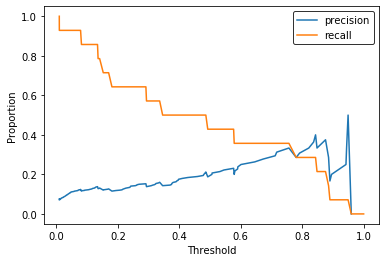

In [156]:
plt.plot(final_recall_precision_data["Threshold"],final_recall_precision_data["p_check"])
plt.plot(final_recall_precision_data["Threshold"],final_recall_precision_data["r_check"])
Legend = plt.legend(('precision', 'recall'), frameon=True, loc='best') 
Legend.get_frame().set_edgecolor('k')  
plt.xlabel('Threshold')  
plt.ylabel('Proportion') 

In [154]:
import pandas as pd
from sklearn import preprocessing

x = final_recall_precision_data[["Threshold","tn","tp","fp","fn"]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final_recall_precision_data_scaled = pd.DataFrame(x_scaled, columns=["Threshold","tn","tp","fp","fn"])


Text(0, 0.5, 'Metric')

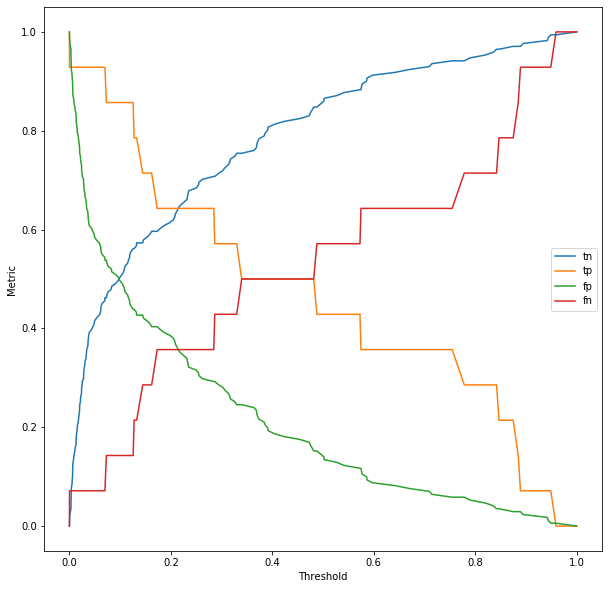

In [153]:
plt.figure(figsize=(10,10))
plt.plot(final_recall_precision_data_scaled["Threshold"],final_recall_precision_data_scaled["tn"])
plt.plot(final_recall_precision_data_scaled["Threshold"],final_recall_precision_data_scaled["tp"])
plt.plot(final_recall_precision_data_scaled["Threshold"],final_recall_precision_data_scaled["fp"])
plt.plot(final_recall_precision_data_scaled["Threshold"],final_recall_precision_data_scaled["fn"])
Legend = plt.legend(('tn', 'tp', 'fp', 'fn'), frameon=True, loc='best') 
plt.xlabel("Threshold")
plt.ylabel("Metric")

In [157]:
! git add .
! git commit -m "adding imbalanced notebook"
! git push

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


Everything up-to-date
